In [1]:
import numpy as np
import tinyarray as ta
import sympy
from collections import OrderedDict
import kwant
import kwant.continuum
import itertools as it

sympy.init_printing(print_builtin=True)

In [2]:
# For plotting
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
import qsymm

In [4]:
from qsymm.model import _commutative_momenta
from qsymm.groups import generate_group
from qsymm.hamiltonian_generator import hamiltonian_from_family
from qsymm.kwant_integration import kp_to_builder, bloch_model_to_builder, bloch_family_to_builder

In [5]:
# Spin matrices
S = qsymm.groups.spin_matrices(1/2)

In [6]:
l = [1, 2]

### Test graphene

In [7]:
# Time reversal
TR = qsymm.PointGroupElement(sympy.eye(2), True, False, np.eye(2))

# Chiral symmetry
C = qsymm.PointGroupElement(sympy.eye(2), False, True, np.array([[1, 0], [0, -1]]))

# Atom A rotates into A, B into B.
sphi = 2*sympy.pi/3
RC3 = sympy.Matrix([[sympy.cos(sphi), -sympy.sin(sphi)],
                  [sympy.sin(sphi), sympy.cos(sphi)]])
C3 = qsymm.PointGroupElement(RC3, False, False, np.eye(2))

symmetries = [C, TR, C3]
# symmetries = [TR, C3]

We set the interatom distance to $1$, so the lattice vectors should have norm $\sqrt{3}$

In [8]:
norbs = OrderedDict({'A': 1, 'B': 1})  # A and B atom per unit cell, one orbital each
hopping_vectors = [('A', 'B', [1, 0])] # Hopping between neighbouring A and B atoms

In [9]:
family = qsymm.bloch_family(hopping_vectors, symmetries, norbs)

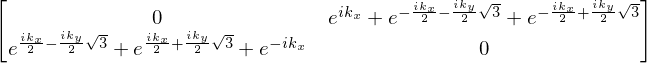

In [10]:
qsymm.display_family(family)

In [11]:
hamfam = hamiltonian_from_family(family)

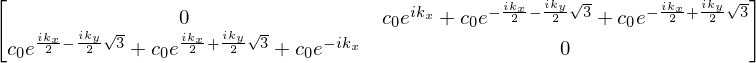

In [12]:
hamfam

In [13]:
fam = qsymm.Model(hamiltonian=hamfam, momenta=family[0].momenta)

In [14]:
# Atomic coordinates within the unit cell
atom_coords = [(0, 0), (1, 0)]
# We set the interatom distance to 1, so the lattice vectors have length sqrt(3)
lat_vecs = [(3/2, np.sqrt(3)/2), (3/2, -np.sqrt(3)/2)]

In [15]:
syst = bloch_model_to_builder(fam, norbs, lat_vecs, atom_coords)
# syst = bloch_model_to_builder(family[0], norbs, lat_vecs, atom_coords)
# g = sympy.Symbol('g', real=True)
# syst = bloch_family_to_builder(family, norbs, lat_vecs, atom_coords, coeffs=[g])

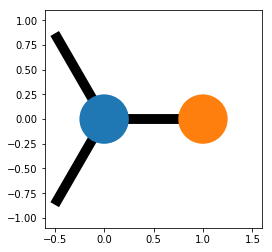

In [16]:
kwant.plot(syst);

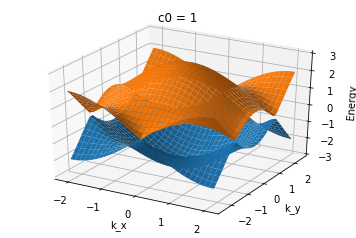

In [17]:
params = dict(c0 = 1)
# params = dict(c0 = 0, c1 = 0, c2 = 1) # if we remove chiral symmetry
# params = dict(g = 1)
wrapped = kwant.wraparound.wraparound(syst).finalized()
kwant.wraparound.plot_2d_bands(wrapped, params=params);

Compare with the correct dispersion

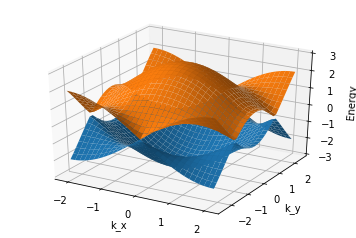

In [18]:
atoms, orbs = zip(*[(atom, norb) for atom, norb in
                    norbs.items()])
# Make the kwant lattice
lat = kwant.lattice.general(lat_vecs,
                            atom_coords,
                            norbs=orbs)
# Store sublattices by name
sublattices = {atom: sublat for atom, sublat in
               zip(atoms, lat.sublattices)}

sym = kwant.TranslationalSymmetry(*lat_vecs)
bulk = kwant.Builder(sym)

bulk[ [sublattices['A'](0, 0), sublattices['B'](0, 0)] ] = 0
bulk[lat.neighbors()] = 1
wrapped = kwant.wraparound.wraparound(bulk).finalized()
kwant.wraparound.plot_2d_bands(wrapped);

### Test MX$_2$

In [19]:
# Time reversal
TR = qsymm.PointGroupElement(sympy.eye(2), True, False, np.eye(3))

# Mirror symmetry 
Mx = qsymm.PointGroupElement(sympy.Matrix([[-1, 0], [0, 1]]), False, False, np.diag([1, -1, 1]))

# Threefold rotation on d_z^2, d_xy, d_x^2-y^2 states.
C3U = np.array([[1, 0, 0],
                 [0, -0.5, -np.sqrt(3)/2],
                 [0, np.sqrt(3)/2, -0.5]])
# Could also use the predefined representation of rotations on d-orbitals
Ld = qsymm.groups.L_matrices(3, 2)
C3U2 = qsymm.groups.spin_rotation(2 * np.pi * np.array([0, 0, 1/3]), Ld)
# Restrict to d_z^2, d_xy, d_x^2-y^2 states
mask = np.array([1, 2 ,0])
C3U2 = C3U2[mask][:, mask]
assert np.allclose(C3U, C3U2)

# The spatial part of the symmetry must be provided as a symbolic matrix
# or an integer array
sphi = 2*sympy.pi/3
C3R = sympy.Matrix([[sympy.cos(sphi), -sympy.sin(sphi)],
                     [sympy.sin(sphi), sympy.cos(sphi)]])
C3 = qsymm.PointGroupElement(C3R, False, False, C3U)

symmetries = [TR, Mx, C3]

In [20]:
# One site per unit cell (M atom), with three orbitals
norbs = OrderedDict({'M': 3})

In [21]:
# Hopping to a neighbouring atom one primitive lattice vector away
hopping_vectors = [('M', 'M', [1, 0])]

In [22]:
family = qsymm.bloch_family(hopping_vectors, symmetries, norbs)

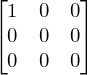

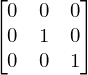

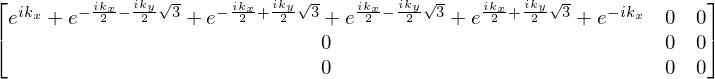

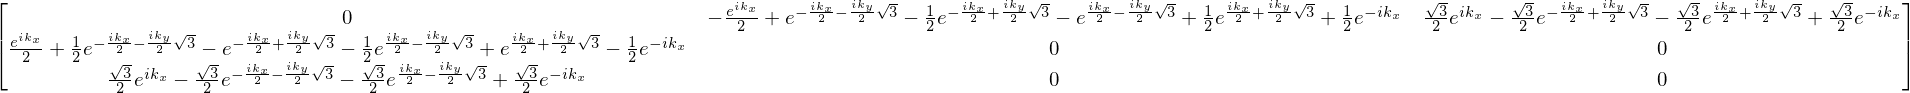

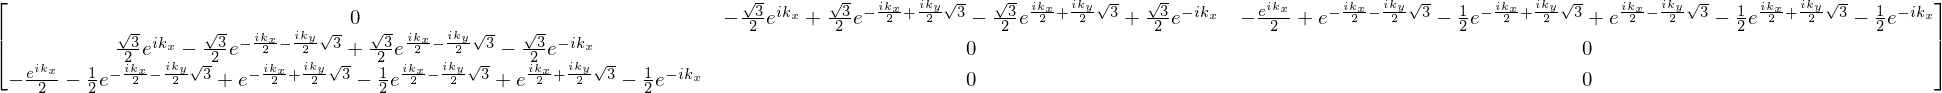

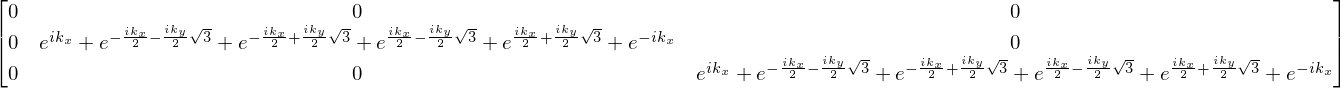

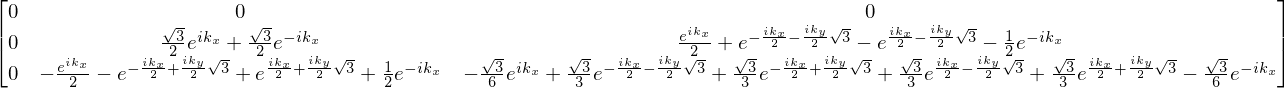

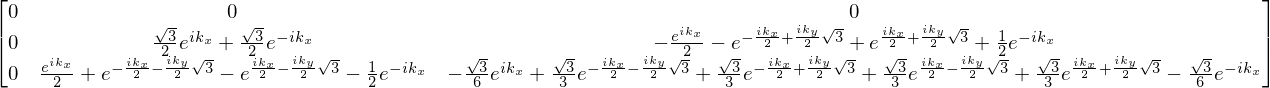

In [23]:
qsymm.display_family(family, nsimplify=True)

In [24]:
hamfam = hamiltonian_from_family(family)
fam = qsymm.Model(hamiltonian=hamfam, momenta=family[0].momenta)

In [25]:
# Atomic coordinates within the unit cell
atom_coords = [(0, 0)]
lat_vecs = [(1, 0), (1/2, np.sqrt(3)/2)]

In [26]:
syst = bloch_model_to_builder(fam, norbs, lat_vecs, atom_coords)
syst = bloch_family_to_builder(family, norbs, lat_vecs, atom_coords)

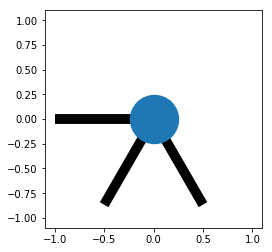

In [27]:
kwant.plot(syst);

In [28]:
f = list(syst.site_value_pairs())[0][-1]

In [29]:
f?

Signature: f(site, c0, c1)
Docstring:
Created with lambdify. Signature:

func(arg_0, arg_1, arg_2)

Expression:

Matrix([[1.0*c0, 0, 0], [0, 1.0*c1, 0], [0, 0, 1.0*c1]])
File:      Dynamically generated function. No source code available.
Type:      function


In [30]:
f(list(syst.sites())[0], 2, 3)

array([[2., 0., 0.],
       [0., 3., 0.],
       [0., 0., 3.]])

In [31]:
f(list(syst.sites())[0], 1, 1).shape